## 第三节：特征工程与基线模型

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm  

class _Data_Preprocess:
    def __init__(self):
        self.int8_max = np.iinfo(np.int8).max
        self.int8_min = np.iinfo(np.int8).min

        self.int16_max = np.iinfo(np.int16).max
        self.int16_min = np.iinfo(np.int16).min

        self.int32_max = np.iinfo(np.int32).max
        self.int32_min = np.iinfo(np.int32).min

        self.int64_max = np.iinfo(np.int64).max
        self.int64_min = np.iinfo(np.int64).min

        self.float16_max = np.finfo(np.float16).max
        self.float16_min = np.finfo(np.float16).min

        self.float32_max = np.finfo(np.float32).max
        self.float32_min = np.finfo(np.float32).min

        self.float64_max = np.finfo(np.float64).max
        self.float64_min = np.finfo(np.float64).min

    def _get_type(self, min_val, max_val, types):
        if types == 'int':
            if max_val <= self.int8_max and min_val >= self.int8_min:
                return np.int8
            elif max_val <= self.int16_max <= max_val and min_val >= self.int16_min:
                return np.int16
            elif max_val <= self.int32_max and min_val >= self.int32_min:
                return np.int32
            return None

        elif types == 'float':
            if max_val <= self.float16_max and min_val >= self.float16_min:
                return np.float16
            if max_val <= self.float32_max and min_val >= self.float32_min:
                return np.float32
            if max_val <= self.float64_max and min_val >= self.float64_min:
                return np.float64
            return None

    def _memory_process(self, df):
        init_memory = df.memory_usage().sum() / 1024 ** 2 / 1024
        print('Original data occupies {} GB memory.'.format(init_memory))
        df_cols = df.columns

          
        for col in tqdm_notebook(df_cols):
            try:
                if 'float' in str(df[col].dtypes):
                    max_val = df[col].max()
                    min_val = df[col].min()
                    trans_types = self._get_type(min_val, max_val, 'float')
                    if trans_types is not None:
                        df[col] = df[col].astype(trans_types)
                elif 'int' in str(df[col].dtypes):
                    max_val = df[col].max()
                    min_val = df[col].min()
                    trans_types = self._get_type(min_val, max_val, 'int')
                    if trans_types is not None:
                        df[col] = df[col].astype(trans_types)
            except:
                print(' Can not do any process for column, {}.'.format(col)) 
        afterprocess_memory = df.memory_usage().sum() / 1024 ** 2 / 1024
        print('After processing, the data occupies {} GB memory.'.format(afterprocess_memory))
        return df

## 3.3 基线模型

### 3.3.1 数据读取

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
path  = 'D:\Documents\天池竞赛\阿里云安全恶意程序检测\dataset\\'
train = pd.read_csv(path + 'security_train.csv')
test  = pd.read_csv(path + 'security_test.csv')

In [3]:
train.head()

,file_id,label,api,tid,index
0,1,5,LdrLoadDll,2488,0
1,1,5,LdrGetProcedureAddress,2488,1
2,1,5,LdrGetProcedureAddress,2488,2
3,1,5,LdrGetProcedureAddress,2488,3
4,1,5,LdrGetProcedureAddress,2488,4


### 3.3.2 特征工程 

In [ ]:
def simple_sts_features(df):
    simple_fea             = pd.DataFrame()
    simple_fea['file_id']  = df['file_id'].unique()
    simple_fea             = simple_fea.sort_values('file_id')
    
    df_grp = df.groupby('file_id')
    simple_fea['file_id_api_count']   = df_grp['api'].count().values
    simple_fea['file_id_api_nunique'] = df_grp['api'].nunique().values
    
    simple_fea['file_id_tid_count']   = df_grp['tid'].count().values
    simple_fea['file_id_tid_nunique'] = df_grp['tid'].nunique().values
    
    simple_fea['file_id_index_count']   = df_grp['index'].count().values
    simple_fea['file_id_index_nunique'] = df_grp['index'].nunique().values
    
    return simple_fea

In [5]:
%%time
simple_train_fea1 = simple_sts_features(train)

Wall time: 51.9 s


In [6]:
%%time
simple_test_fea1 = simple_sts_features(test)

Wall time: 44.5 s


In [11]:
simple_test_fea1

,file_id,file_id_api_count,file_id_api_nunique,file_id_tid_count,file_id_tid_nunique,file_id_index_count,file_id_index_nunique
0,1,97,15,97,4,97,31
1,2,1361,40,1361,7,1361,681
2,3,16,9,16,1,16,16
3,4,193,34,193,3,193,193
4,5,803,34,803,3,803,268
...,...,...,...,...,...,...,...
12950,12951,289,37,289,6,289,145
12951,12952,112,28,112,1,112,112
12952,12953,5095,72,5095,15,5095,1464
12953,12954,2951,65,2951,4,2951,1445


In [ ]:
def simple_numerical_sts_features(df):
    simple_numerical_fea             = pd.DataFrame()
    simple_numerical_fea['file_id']  = df['file_id'].unique()
    simple_numerical_fea             = simple_numerical_fea.sort_values('file_id')
     
    df_grp = df.groupby('file_id')
    
    simple_numerical_fea['file_id_tid_mean']  = df_grp['tid'].mean().values
    simple_numerical_fea['file_id_tid_min']   = df_grp['tid'].min().values
    simple_numerical_fea['file_id_tid_std']   = df_grp['tid'].std().values
    simple_numerical_fea['file_id_tid_max']   = df_grp['tid'].max().values
    
    simple_numerical_fea['file_id_index_mean']= df_grp['index'].mean().values
    simple_numerical_fea['file_id_index_min'] = df_grp['index'].min().values
    simple_numerical_fea['file_id_index_std'] = df_grp['index'].std().values
    simple_numerical_fea['file_id_index_max'] = df_grp['index'].max().values
    
    return simple_numerical_fea

In [8]:
%%time
simple_train_fea2 = simple_numerical_sts_features(train)

Wall time: 7.09 s


In [9]:
%%time
simple_test_fea2 = simple_numerical_sts_features(test)

Wall time: 6.28 s


In [10]:
simple_test_fea2

,file_id,file_id_tid_mean,file_id_tid_min,file_id_tid_std,file_id_tid_max,file_id_index_mean,file_id_index_min,file_id_index_std,file_id_index_max
0,1,2518.639175,2332,57.218548,2568,14.443299,0,9.210466,30
1,2,2576.864071,2472,104.399149,2748,339.750184,0,196.515744,680
2,3,2344.000000,2344,0.000000,2344,7.500000,0,4.760952,15
3,4,2476.331606,2452,50.951508,2584,96.000000,0,55.858452,192
4,5,2496.149440,2332,201.826813,2780,133.333748,0,77.317048,267
...,...,...,...,...,...,...,...,...,...
12950,12951,2716.539792,2644,75.402526,2980,71.750865,0,41.786414,144
12951,12952,2264.000000,2264,0.000000,2264,55.500000,0,32.475632,111
12952,12953,2622.118155,2324,196.695730,2884,538.423749,0,393.605016,1463
12953,12954,2593.646899,2424,126.124152,2700,596.701796,0,397.358069,1444


### 3.3.3 基线构建

- `.drop_duplicates(subset = ['file_id','label'], keep = 'first')`: 这个方法用于删除DataFrame中的重复行。
    - `subset = ['file_id','label']`参数指定了在考虑重复时只考虑`file_id`和`label`这两列。
    - `keep = 'first'`参数意味着在发现重复行时，会保留第一次出现的行，删除其余的重复行。
- `train_label`: 这是一个新的DataFrame，包含了去重后的数据。

总结来说，这段代码的目的是清理数据集，确保每个`file_id`在训练集和测试集中都是唯一的，没有重复的条目。这对于避免在模型训练和测试过程中出现数据泄露非常重要。


In [12]:
train_label = train[['file_id','label']].drop_duplicates(subset = ['file_id','label'], keep = 'first')
test_submit = test[['file_id']].drop_duplicates(subset = ['file_id'], keep = 'first')

In [24]:
train[['file_id','label']].drop_duplicates(subset = ['file_id','label'], keep = 'first').reset_index(drop = True)

,file_id,label
0,1,5
1,2,2
2,3,0
3,4,0
4,5,0
...,...,...
13882,13883,2
13883,13884,5
13884,13885,0
13885,13886,1


In [ ]:
### 训练集&测试集构建
train_data = train_label.merge(simple_train_fea1, on ='file_id', how='left') 
train_data = train_data.merge(simple_train_fea2, on ='file_id', how='left')

test_submit = test_submit.merge(simple_test_fea1, on ='file_id', how='left')
test_submit = test_submit.merge(simple_test_fea2, on ='file_id', how='left')

In [23]:
train_data

,file_id,label,file_id_api_count,file_id_api_nunique,file_id_tid_count,file_id_tid_nunique,file_id_index_count,file_id_index_nunique,file_id_tid_mean,file_id_tid_min,file_id_tid_std,file_id_tid_max,file_id_index_mean,file_id_index_min,file_id_index_std,file_id_index_max
0,1,5,6786,116,6786,11,6786,5001,2537.987622,2488,83.881299,2812,2000.806955,0,1510.694221,5000
1,2,2,816,30,816,4,816,204,2471.000000,2320,101.506783,2604,101.500000,0,58.925137,203
2,3,0,463,42,463,1,463,463,2208.000000,2208,0.000000,2208,231.000000,0,133.800847,462
3,4,0,2046,51,2046,9,2046,1028,2430.727273,2284,150.460506,2980,511.012219,0,295.407885,1027
4,5,0,10002,65,10002,6,10002,5001,2549.731254,2500,49.556301,2676,2500.000000,0,1443.736493,5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13882,13883,2,178221,71,178221,998,178221,5001,3544.762896,100,1405.045515,6568,401.480987,0,1008.636040,5000
13883,13884,5,1319,39,1319,2,1319,1319,2592.118271,2592,4.295386,2748,659.000000,0,380.906813,1318
13884,13885,0,1033,71,1033,3,1033,1033,2242.544046,2240,33.152020,2744,516.000000,0,298.345717,1032
13885,13886,1,5316,80,5316,10,5316,2503,2483.399549,2324,154.796790,2836,1173.050414,0,755.545651,2502


这段代码定义了一个函数lgb_logloss，用于计算LightGBM模型的对数损失（log loss），也称为交叉熵损失。这种损失函数常用于多分类问题。

In [ ]:
import numpy as np

def lgb_logloss(preds, data):
    # 获取数据集中的真实标签
    labels_ = data.get_label()
    # 获取所有可能的类别
    classes_ = np.unique(labels_)
    # 初始化一个列表，用于存储每个类别的预测概率
    preds_prob = []
    # 对于每个类别，将预测结果分割成相应的部分
    for i in range(len(classes_)):
        # 假设preds是按类别顺序排列的概率数组
        preds_prob.append(preds[i * len(labels_):(i + 1) * len(labels_)])
    # 将列表转换为numpy数组，以便于后续计算
    preds_prob_ = np.vstack(preds_prob)
    
    loss = []
    for i in range(preds_prob_.shape[1]): 
        sum_ = 0
        # 遍历每个类别
        for j in range(preds_prob_.shape[0]):
            # 获取第i个样本预测为第j类的概率
            pred = preds_prob_[j, i]
            # 如果预测的类别与真实类别相同，则计算该类别的对数概率
            if j == labels_[i]:
                sum_ += np.log(pred)
            # 否则，计算1减去该类别概率的对数（即其他类别的概率）
            else:
                sum_ += np.log(1 - pred)
        # 将计算得到的对数概率和添加到损失列表中
        loss.append(sum_)
    # 返回损失信息，损失值是所有样本损失的平均值的负数
    return 'loss is: ', -1 * (np.sum(loss) / preds_prob_.shape[1]), False

In [15]:
### 模型验证
train_features = [col for col in train_data.columns if col not in ['label','file_id']]
train_label    = 'label'

In [16]:
%%time
from sklearn.model_selection import StratifiedKFold,KFold
params = {
        'task':'train', 
        'num_leaves': 255,
        'objective': 'multiclass',
        'num_class': 8,
        'min_data_in_leaf': 50,
        'learning_rate': 0.05,
        'feature_fraction': 0.85,
        'bagging_fraction': 0.85,
        'bagging_freq': 5, 
        'max_bin':128,
        'random_state':100
    }   

folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))

predict_res = 0
models = []
# folds是之前定义好的KFold对象，用于生成训练集和验证集的索引
# models是一个列表，用于存储每一折训练得到的模型
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_data)):
    print("fold n°{}".format(fold_))
    # 根据folds.split生成的索引，分割训练数据和验证数据，trn_idx是当前折的训练集索引，val_idx是验证集索引
    trn_data = lgb.Dataset(train_data.iloc[trn_idx][train_features], label=train_data.iloc[trn_idx][train_label].values)
    val_data = lgb.Dataset(train_data.iloc[val_idx][train_features], label=train_data.iloc[val_idx][train_label].values)
    
    # 初始化LightGBM模型
    clf = lgb.train(
        params,  # 使用之前定义的参数
        trn_data,  # 训练数据集
        num_boost_round=2000,  # 训练迭代的次数
        valid_sets=[trn_data, val_data],  # 验证集，这里同时使用了训练集和验证集进行评估
        verbose_eval=50,  # 每50次迭代输出一次训练信息
        early_stopping_rounds=100,  # 如果在100次迭代中性能没有提升，则提前停止训练
        feval=lgb_logloss  # 使用自定义的对数损失函数作为评估指标
    )
    
    # 将训练好的模型添加到models列表中
    models.append(clf)

fold n°0
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1664
[LightGBM] [Info] Number of data points in the train set: 11109, number of used features: 13
[LightGBM] [Info] Start training from score -1.029745
[LightGBM] [Info] Start training from score -3.344249
[LightGBM] [Info] Start training from score -2.487882
[LightGBM] [Info] Start training from score -2.805253
[LightGBM] [Info] Start training from score -4.861164
[LightGBM] [Info] Start training from score -1.173157
[LightGBM] [Info] Start training from score -3.277640
[LightGBM] [Info] Start training from score -2.214659
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

LightGBM（Light Gradient Boosting Machine）是一款基于决策树算法的分布式梯度提升框架，由微软开发。它以其高效、准确和易于使用的特点，在数据科学领域广受欢迎。LightGBM的设计初衷是提供一个快速高效、低内存占用、高准确度、支持并行和大规模数据处理的数据科学工具。

LightGBM的核心优势包括：

1. **更快的训练效率**：通过使用基于直方图算法，LightGBM在训练速度上比传统方法快很多。
2. **低内存使用**：LightGBM在大数据集上的表现尤为出色，因为它不需要对整个数据集进行加载，而是可以处理数据流。
3. **更高的准确率**：LightGBM采用了基于叶子的生长策略（leaf-wise growth），这有助于提高模型的准确率。
4. **支持并行化学习**：LightGBM支持多核并行和GPU学习，这使得它在处理大规模数据时更加高效。
5. **可处理大规模数据**：LightGBM能够处理大规模数据集，这得益于其高效的数据存储和处理方式。
6. **支持直接使用类别特征**：LightGBM可以直接使用类别特征，无需进行额外的预处理。

LightGBM的模型架构主要包括数据预处理、数据切分、构建初始模型、迭代训练、评估与优化等步骤。在迭代训练过程中，LightGBM采用梯度提升的方式进行训练，每次迭代都会生成新的决策树，并计算梯度，通过不断更新模型，使得模型的输出逐渐逼近真实值。

此外，LightGBM还提供了多种参数调整选项，允许用户根据具体问题进行定制化优化。它的应用范围广泛，包括但不限于分类、回归、排名等机器学习任务。由于其出色的性能，LightGBM在Kaggle等数据科学竞赛中也得到了广泛的应用。


### 3.3.4 特征重要性分析

In [ ]:
# 假设clf是之前训练好的LightGBM模型

feature_importance = pd.DataFrame()

# 将特征名称赋值给DataFrame的'fea_name'列
feature_importance['fea_name'] = train_features

# 使用模型的feature_importance()方法获取特征重要性分数，并赋值给'fea_imp'列，这个方法返回一个数组，其中包含模型中每个特征的重要性分数
feature_importance['fea_imp'] = clf.feature_importance()

# 对DataFrame按照'fea_imp'列的值进行降序排序，即重要性分数高的排在前面， ascending=False表示降序排序，如果设置为True则为升序排序
feature_importance = feature_importance.sort_values('fea_imp', ascending=False)

<AxesSubplot:xlabel='fea_name', ylabel='fea_imp'>

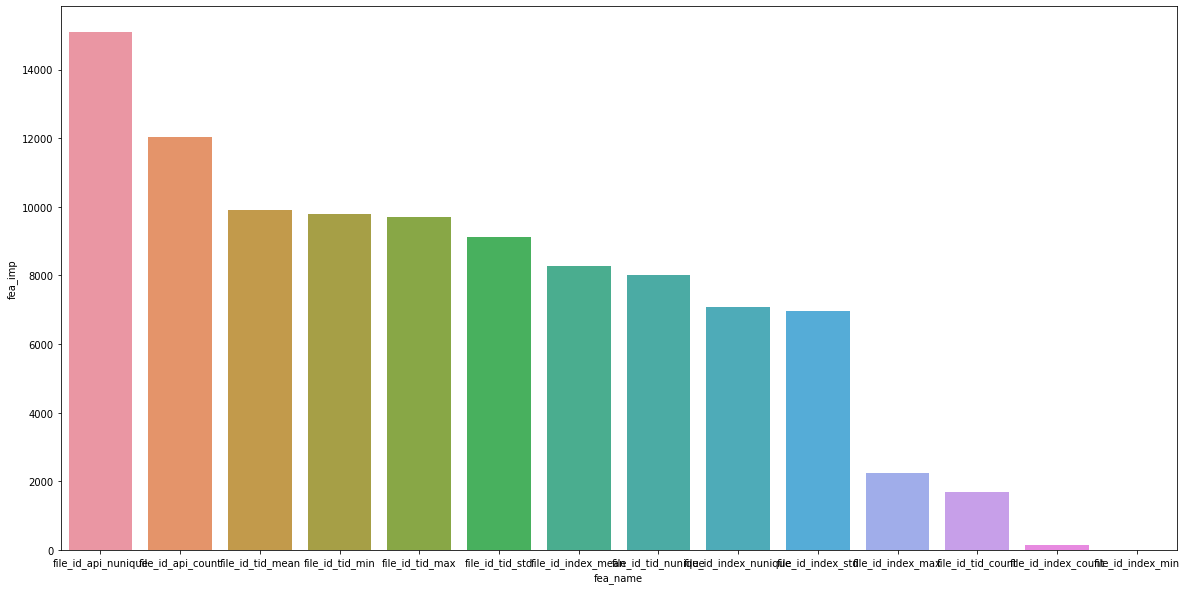

In [20]:
plt.figure(figsize=[20, 10,])
sns.barplot(x = feature_importance['fea_name'], y = feature_importance['fea_imp'])
#sns.barplot(x="fea_name",y="fea_imp",data=feature_importance)

### 3.3.5 模型测试

In [25]:
pred_res = 0
fold = 5
for model in models:
    pred_res +=model.predict(test_submit[train_features]) * 1.0 / fold 

In [26]:
test_submit['prob0'] = 0
test_submit['prob1'] = 0
test_submit['prob2'] = 0
test_submit['prob3'] = 0
test_submit['prob4'] = 0
test_submit['prob5'] = 0
test_submit['prob6'] = 0
test_submit['prob7'] = 0

In [ ]:
test_submit[['prob0','prob1','prob2','prob3','prob4','prob5','prob6','prob7']] = pred_res
test_submit[['file_id','prob0','prob1','prob2','prob3','prob4','prob5','prob6','prob7']].to_csv(path+'baseline.csv',index = None)

In [28]:
test_submit

,file_id,file_id_api_count,file_id_api_nunique,file_id_tid_count,file_id_tid_nunique,file_id_index_count,file_id_index_nunique,file_id_tid_mean,file_id_tid_min,file_id_tid_std,...,file_id_index_std,file_id_index_max,prob0,prob1,prob2,prob3,prob4,prob5,prob6,prob7
0,1,97,15,97,4,97,31,2518.639175,2332,57.218548,...,9.210466,30,0.004749,0.000353,0.085996,0.000806,0.000037,0.105967,0.000438,0.001654
1,2,1361,40,1361,7,1361,681,2576.864071,2472,104.399149,...,196.515744,680,0.025583,0.005687,0.007471,0.001135,0.000310,0.089422,0.036935,0.033457
2,3,16,9,16,1,16,16,2344.000000,2344,0.000000,...,4.760952,15,0.162861,0.000317,0.023450,0.000235,0.000031,0.007922,0.000370,0.004814
3,4,193,34,193,3,193,193,2476.331606,2452,50.951508,...,55.858452,192,0.154197,0.000156,0.003515,0.003716,0.000067,0.006528,0.000365,0.031455
4,5,803,34,803,3,803,268,2496.149440,2332,201.826813,...,77.317048,267,0.005704,0.000165,0.184212,0.000878,0.000025,0.005488,0.000549,0.002980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12950,12951,289,37,289,6,289,145,2716.539792,2644,75.402526,...,41.786414,144,0.146929,0.000747,0.002068,0.002258,0.002661,0.006559,0.000576,0.038202
12951,12952,112,28,112,1,112,112,2264.000000,2264,0.000000,...,32.475632,111,0.176636,0.000152,0.000600,0.000631,0.000066,0.015529,0.000874,0.005512
12952,12953,5095,72,5095,15,5095,1464,2622.118155,2324,196.695730,...,393.605016,1463,0.001421,0.000363,0.000553,0.000583,0.000027,0.191841,0.002246,0.002967
12953,12954,2951,65,2951,4,2951,1445,2593.646899,2424,126.124152,...,397.358069,1444,0.004506,0.000069,0.000283,0.000577,0.000113,0.193306,0.000733,0.000412


In [32]:
test_submit.to_csv(path+'submit.csv', index=False)